In [9]:
import train_cnn
import stacked_ae
from utils import *
import matplotlib.pyplot as plt 
import numpy as np
import imp
imp.reload(train_cnn)
imp.reload(stacked_ae)
%matplotlib inline

### For CNN

In [33]:
# Training CNN --> it took 2min (simple), 5min (2 convs)
# X, X_fullsize, Y, contour_mask, y_pred, h = train_cnn.run(model='simple', history=True)
# X1, X_fullsize1, Y1, contour_mask1, y_pred1, h1 = train_cnn.run(model='larger', history=True)
# X2, X_fullsize2, Y2, contour_mask2, y_pred2, h2 = train_cnn.run(model='deeper', history=True)
# X3, X_fullsize3, Y3, contour_mask3, y_pred3, h3 = train_cnn.run(model='maxpooling', history=True)
X4, X_fullsize4, Y4, contour_mask4, y_pred4, h4 = train_cnn.run(model='simple', history=True, activation='relu')

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


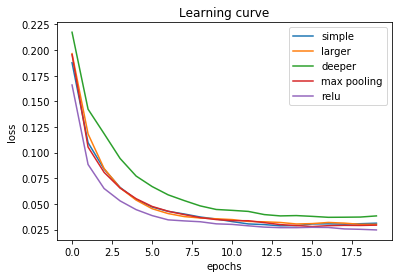

In [34]:
metric = 'loss'
it = range(len(h.history[metric]))
plt.plot(it, h.history[metric], label='simple')
plt.plot(it, h1.history[metric], label='larger')
plt.plot(it, h2.history[metric], label='deeper')
plt.plot(it, h3.history[metric], label='max pooling')
plt.plot(it, h4.history[metric], label='relu')
plt.ylabel(metric)
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()

In [35]:
# Training stacked AE --> it took 23s
# X_train, Y_train, binarys = stacked_ae.run(X_fullsize, y_pred, contour_mask)
# X_train1, Y_train1, binarys1 = stacked_ae.run(X_fullsize1, y_pred1, contour_mask1)
# X_train2, Y_train2, binarys2 = stacked_ae.run(X_fullsize2, y_pred2, contour_mask2)
# X_train3, Y_train3, binarys3 = stacked_ae.run(X_fullsize3, y_pred3, contour_mask3)
X_train4, Y_train4, binarys4 = stacked_ae.run(X_fullsize4, y_pred4, contour_mask4)

For the full dataset :
Dice Metric : 0.33
Conformity Coefficient : -24.40
For the full dataset :
Dice Metric : 0.44
Conformity Coefficient : -10.69
For the full dataset :
Dice Metric : 0.37
Conformity Coefficient : -20.20
For the full dataset :
Dice Metric : 0.39
Conformity Coefficient : -12.30
For the full dataset :
Dice Metric : 0.40
Conformity Coefficient : -12.25
277


Text(0.5,1,'Ground Truth')

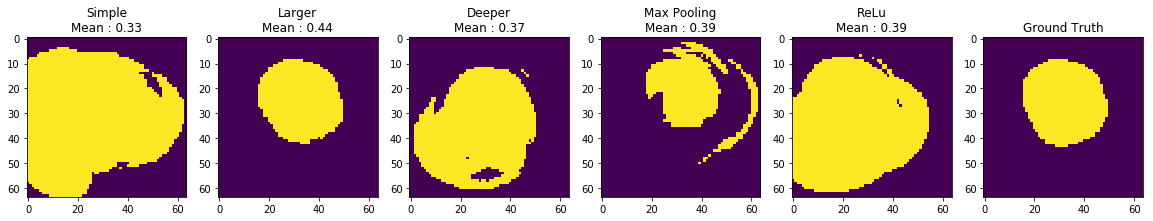

In [39]:
idx = 277
dm, cc  = stats_results(Y_train, binarys)
dm1, cc1  = stats_results(Y_train1, binarys1)
dm2, cc2  = stats_results(Y_train2, binarys2)
dm3, cc3  = stats_results(Y_train3, binarys3)
dm4, cc4  = stats_results(Y_train4, binarys4)

print(np.argmax(dm1))

f, ax = plt.subplots(ncols=6, figsize=(20,5))
ax[0].imshow(binarys[idx])
ax[0].set_title('Simple\nMean : %.2f' % dm.mean())
ax[1].imshow(binarys1[idx])
ax[1].set_title('Larger\nMean : %.2f' % dm1.mean())
ax[2].imshow(binarys2[idx])
ax[2].set_title('Deeper\nMean : %.2f' % dm2.mean())
ax[3].imshow(binarys3[idx])
ax[3].set_title('Max Pooling\nMean : %.2f' % dm3.mean())
ax[4].imshow(binarys4[idx])
ax[4].set_title('ReLu\nMean : %.2f' % dm3.mean())
ax[5].imshow(Y_train[idx].reshape((64,64)))
ax[5].set_title('Ground Truth')

**To do for Test**  
1. Il faut créer des nouvelles fonctions pour le test genre par exemple une autre fonction de model dans le CNN qui integrerait une nouvelle couche de convolution, ou qui soit avec des Relus, ou des filtres de tailles différentes, etc. et idem pour le stacked AE : changer les inits OK, change la taille de 100x100 par autres choses et faire que ses fonctions soient justes des options des .run() au dessus
2.  Tester sur le test set ! 

### For Stacked AE

In [2]:
_, X_fullsize, _, contour_mask, y_pred, h = train_cnn.run(model='simple', history=True)

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


In [10]:
X_train, Y_train, binarys, h = stacked_ae.run(X_fullsize, y_pred, contour_mask, X_to_pred=None, verbose=0, param_reg=3*0.001, init_3='zero',history=True)
X_train1, Y_train1, binarys1, h1 = stacked_ae.run(X_fullsize, y_pred, contour_mask, X_to_pred=None, verbose=0, param_reg=3*0.001, init_3='random_uniform', history=True)
X_train2, Y_train2, binarys2, h2 = stacked_ae.run(X_fullsize, y_pred, contour_mask, X_to_pred=None, verbose=0, param_reg=3*0.001, init_3='random_normal', history=True)

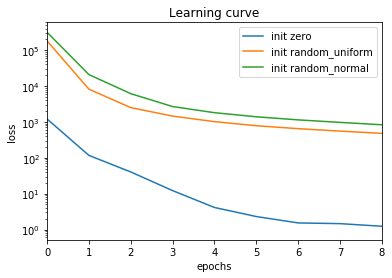

In [21]:
metric = 'loss'
it = range(len(h))
plt.plot(it, h, label='init zero')
plt.plot(it, h1, label='init random_uniform')
plt.plot(it, h2, label='init random_normal')
plt.ylabel(metric)
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')